In this notebook, we have utilities for imputing missing data in the Enefit time series using MICE https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html

Citation:
Kristjan Eljand, Martin Laid, Jean-Baptiste Scellier, Sohier Dane, Maggie Demkin, Addison Howard. (2023). 
Enefit - Predict Energy Behavior of Prosumers. Kaggle. https://kaggle.com/competitions/predict-energy-behavior-of-prosumers


In [11]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import random

from datetime import datetime, timedelta
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from functools import reduce



# 1. Separating the time series

The Enefit training set consists of separate time series, each of them corresponding to a quadruple (county_value, is_business_value, is_consumption_value, product_type_value). We call such quadruples the signature of a time series. In the following code, we define a class that separates the training set into the different time series, each of them corresponding to a column in a new dataframe.

In [12]:
class SignedTimeSeries:
    """
    Creates a dataframe indexed by the datetime when a reading is take, and whose columns are the target values in each time series. Signed means that we assign each column to a signature.
    """
    
    def __init__(self, df):
        self.df = df
        self.data = self.separate()

    def separate(self):
        signed_series=[]
        for group, group_df in df.groupby(['county', 'is_business', 'is_consumption', 'product_type']):
            signature=(group_df['county'].iloc[0], group_df['is_business'].iloc[0], group_df['is_consumption'].iloc[0], group_df['product_type'].iloc[0])
            group_df = group_df.set_index('datetime')
            group_df=group_df[['target']].copy()
            group_df.rename(columns={'target': 'target' +'_' +str(int(signature[0]))+'_'+str(int(signature[1]))+'_'+ str(int(signature[2]))+'_'+ str(int(signature[3]))}, inplace=True)
            signed_series.append(group_df)
        separated_series = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True, how='outer'), signed_series)   
        return separated_series
        
sts = SignedTimeSeries(df)

# 2. Impute time series

The SignedTimeSeries defined above has NaN values. We now impute those values, starting from the series that need less data imputed and moving on to the series that need more. We impute in series with signature (c, ib, ic, pt) by using series with signature (x, ib, ic, pt), where x ranges through all available county values. This is because such series are highly correlated.

In [104]:
# Global function for imputing any column in any data
def impute(df, column, scale = True): # set all_corr = True to impute using ALL series that are highly correlated (>0.9) with the one we want to impute, not just those sharing the same
                                          # is_business, is_consumption, and product_type value.
    if scale == True:   # we first scale the columns
        max_vals={columns: df[columns].max() for columns in df.columns}
    df=df.div(max_vals, axis=1)
    # Impute values
    imputer = IterativeImputer()
    imputed_data = pd.DataFrame(imputer.fit_transform(df), columns=df.columns, index=df.index)
    if scale ==  True: # scale back
        imputed_data= imputed_data.multiply(max_vals, axis=1)
    return imputed_data
        

    
class ImputedTimeSeries(SignedTimeSeries):
    """
    class that imputes the missing values and calculates the error on a random 28-day test set
    """
    
    def nan_signatures(self): #returns a dictionary whose keys are the column names that contain NaN values, and values are the lengths of the data that needs to be imputed
        values={}
        for column in self.data.columns:
            nan_count = self.data[column].isna().sum()
            if nan_count > 0:
                values[column]=nan_count
        return values

    
    
    def impute(self, column, all_corr = False, scale = True): # set all_corr = True to impute using ALL series that are highly correlated (>0.9) with the one we want to impute, not just those sharing the same
                                          # is_business, is_consumption, and product_type value.
        # get relevant columns
        if all_corr == False:
            relevant_columns=[columns for columns in self.data.columns if columns[-5:]==column[-5:]]
        else:
            relevant_columns = self.corr_signature(column).index.to_list()
        new_data = self.data[relevant_columns]
        imputed_data=impute(new_data, column, scale = scale)
        self.data[column] = imputed_data[column]
    
    
    def calculate_error(self, column, all_corr = False, scale = True, visualize = False): #plots and calculates error on a random subset of 4 weeks' data 
        # if all_corr = True, we impute using all series that are highly correlated with this column
        # set visualize to True to plot
        # get the month range
        non_nan_periods = self.data[self.data[column].notna()].resample('28D').mean().dropna().index
        ind = random.randint(0, len(non_nan_periods) - 1); 
        start_date = non_nan_periods[ind]; end_date = start_date + timedelta(days=28)
        range_start = self.data.index.get_loc(start_date); range_end = range_start+28*24;
        # replace some values by NaN
        # get relevant columns
        if all_corr == False:
            relevant_columns=[columns for columns in self.data.columns if columns[-5:]==column[-5:]]
        else:
            relevant_columns = self.corr_signature(column).index.to_list()
        test_data = self.data[relevant_columns].copy()
        test_data.loc[start_date : end_date, column] = np.nan
        imputed_data=impute(test_data, column, scale = scale)
        # plot range
        if visualize == True:
            plt.figure(figsize=(18, 8))
            plt.plot(self.data.index.to_list()[range_start:range_end], self.data[column].to_list()[range_start:range_end], label='Original')
            plt.plot(self.data.index.to_list()[range_start:range_end], imputed_data[column].to_list()[range_start:range_end], label='Imputed data', linestyle='--')
            plt.title('Comparison of Original vs. Imputed Time Series with Shaded Area')
            plt.xlabel('Datetime')
            plt.ylabel('Values')
            plt.legend()
        # calculate error
        return tf.keras.metrics.mean_absolute_error(self.data[column].to_list()[range_start:range_end], imputed_data[column].to_list()[range_start:range_end]).numpy()


    def corr_signature(self, column): #obtains the correlations of specific column with all other columns
        nans= self.nan_signatures().keys()
        full_columns = [column for column in self.data.columns if column not in nans]+[column]
        correlations = self.data[full_columns].corr()[column]
        return correlations[correlations > 0.9]


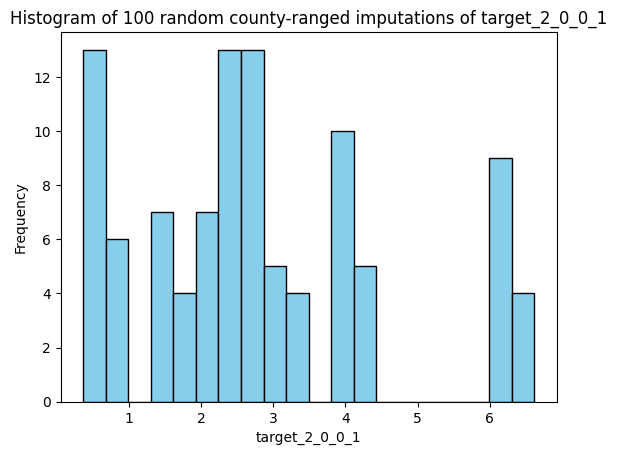